In [ ]:
# https://captum.ai/tutorials/Titanic_Basic_Interpret

In [1]:
import torch
import torchvision

import numpy as np
from scipy import stats
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# Download dataset from: https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv
# Update path to dataset here.
dataset_path = "titanic3.csv"
titanic_data = pd.read_csv(dataset_path)

In [9]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'],prefix="class")], axis=1)
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())
titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)

# Set random seed for reproducibility.
np.random.seed(131254)

# Convert features and labels to numpy arrays.
labels = titanic_data["survived"].to_numpy()
titanic_data = titanic_data.drop(['survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

In [10]:
import torch
import torch.nn as nn

torch.manual_seed(1)  # Set seed for reproducibility.

class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In [11]:
# We can either use a pretrained model or train the network using the training data for 200 epochs. Note that the results of later steps may not match if retraining.
# The pretrained model can be downloaded here: https://github.com/pytorch/captum/blob/master/tutorials/models/titanic_model.pt

In [14]:
net = TitanicSimpleNNModel()
USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load('models/titanic_model.pt'))
    print("Model Loaded!")
else:
    criterion = nn.CrossEntropyLoss()
    num_epochs = 200

    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(train_labels)
    for epoch in range(num_epochs):    
        output = net(input_tensor)
        loss = criterion(output, label_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

    torch.save(net.state_dict(), 'models/titanic_model.pt')

Epoch 1/200 => Loss: 0.67
Epoch 21/200 => Loss: 0.53
Epoch 41/200 => Loss: 0.50
Epoch 61/200 => Loss: 0.49
Epoch 81/200 => Loss: 0.48
Epoch 101/200 => Loss: 0.48
Epoch 121/200 => Loss: 0.48
Epoch 141/200 => Loss: 0.48
Epoch 161/200 => Loss: 0.48
Epoch 181/200 => Loss: 0.49


In [15]:
# Train accuracy

out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8187772925764192


In [16]:
# Test accuracy

test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)

print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.7989821882951654


In [18]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [31]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

# Feature Attributions

In [ ]:
ig = IntegratedGradients(net)
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

Average Feature Importances
age :  -0.310
sibsp :  -0.045
parch :  -0.011
fare :  -0.002
female :  0.077
male :  -0.426
embark_C :  0.103
embark_Q :  0.011
embark_S :  -0.031
class_1 :  0.102
class_2 :  0.040
class_3 :  -0.180


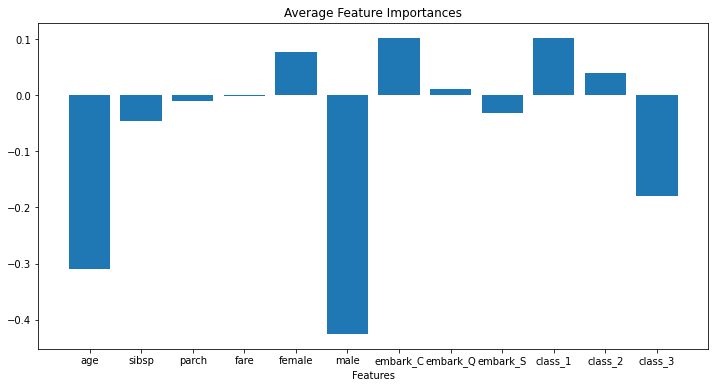

In [19]:
visualize_importances(feature_names, np.mean(attr, axis=0))

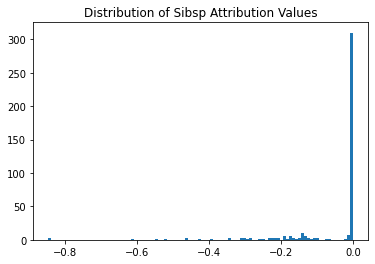

In [20]:
plt.hist(attr[:,1], 100);
plt.title("Distribution of Sibsp Attribution Values");

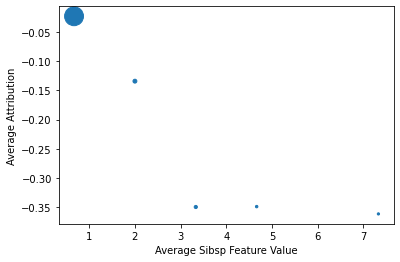

In [21]:
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='mean', bins=6)
bin_count, _, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Sibsp Feature Value");
plt.ylabel("Average Attribution");

# Layer Attributions

In [22]:
cond = LayerConductance(net, net.sigmoid1)
cond_vals = cond.attribute(test_input_tensor,target=1)
cond_vals = cond_vals.detach().numpy()

Average Neuron Importances
0 :  0.026
1 :  -0.232
2 :  0.001
3 :  -0.145
4 :  -0.041
5 :  -0.039
6 :  0.022
7 :  0.003
8 :  -0.118
9 :  -0.144
10 :  0.029
11 :  0.009


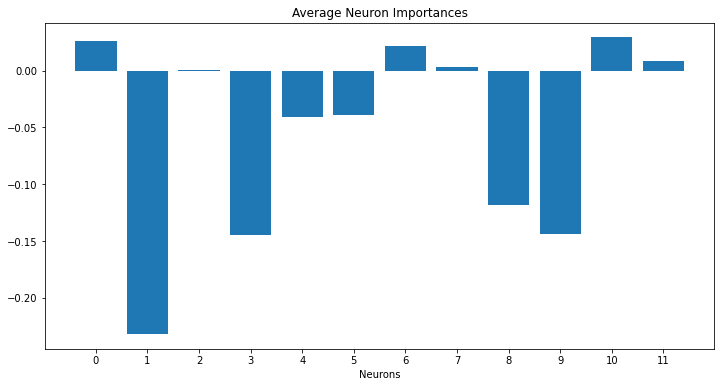

In [23]:
visualize_importances(range(12),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

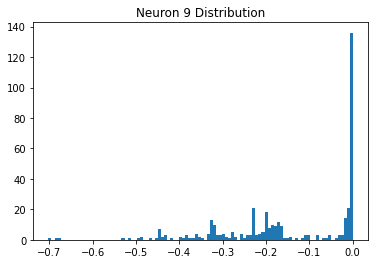

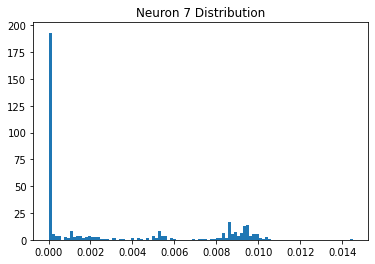

In [24]:
plt.hist(cond_vals[:,9], 100);
plt.title("Neuron 9 Distribution")
plt.figure()
plt.hist(cond_vals[:,7], 100);
plt.title("Neuron 7 Distribution");

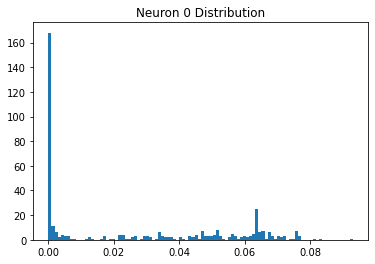

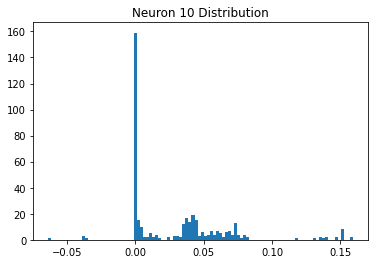

In [27]:
plt.hist(cond_vals[:,0], 100);
plt.title("Neuron 0 Distribution")
plt.figure()
plt.hist(cond_vals[:,10], 100);
plt.title("Neuron 10 Distribution");

# Neuron Attributions


Average Feature Importances for Neuron 0
age :  0.017
sibsp :  -0.001
parch :  -0.000
fare :  0.017
female :  0.000
male :  -0.005
embark_C :  0.000
embark_Q :  0.001
embark_S :  -0.002
class_1 :  0.000
class_2 :  0.000
class_3 :  0.000


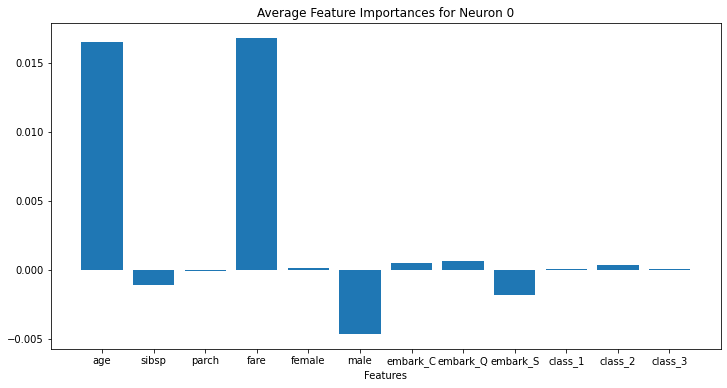

In [29]:
neuron_cond = NeuronConductance(net, net.sigmoid1)
neuron_cond_vals_10 = neuron_cond.attribute(test_input_tensor, neuron_selector=10, target=1)
neuron_cond_vals_0 = neuron_cond.attribute(test_input_tensor, neuron_selector=0, target=1)
visualize_importances(feature_names, neuron_cond_vals_0.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 0")

Average Feature Importances for Neuron 10
age :  -0.002
sibsp :  -0.001
parch :  0.000
fare :  0.040
female :  0.000
male :  -0.009
embark_C :  0.002
embark_Q :  0.001
embark_S :  -0.001
class_1 :  0.000
class_2 :  0.001
class_3 :  -0.001


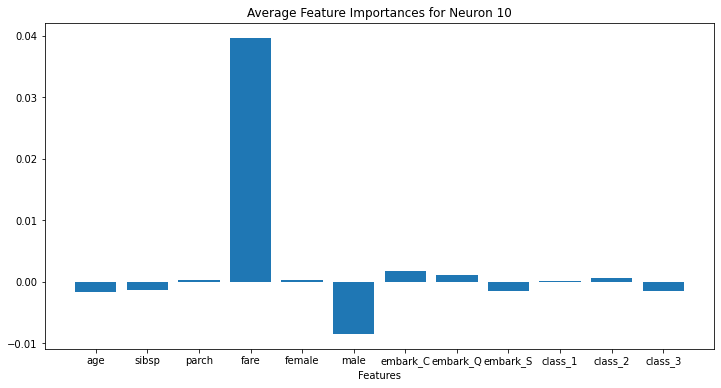

In [30]:
visualize_importances(feature_names, neuron_cond_vals_10.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 10")